In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,precision_score, recall_score, confusion_matrix, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from boruta import BorutaPy

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping

In [2]:
# Load data
data = pd.read_csv('C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv', sep=',')
print(data.shape)

# Separate features and target variable
X = data.drop(columns=['y'])
Y = data['y']

(45211, 33)


In [3]:
# Define numerical features
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Normalize numerical features
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])


In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [5]:
# SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)

In [17]:
# Class distribution before SMOTEENN
print("total samples before SMOTEENN:", len(X))
print("Class distribution before SMOTEENN:")
print(y_train.value_counts())
# Print percentages
print("Class distribution percentages:")
print(y_train.value_counts(normalize=True) * 100)
# Check class distribution
print("total samples after SMOTEENN:", len(y_resample))
print("Class distribution after SMOTEENN:")
print(y_resample.value_counts())
# Print percentages
print("Class distribution percentages:")
print(y_resample.value_counts(normalize=True) * 100)

total samples before SMOTEENN: 45211
Class distribution before SMOTEENN:
y
0    31937
1     4231
Name: count, dtype: int64
Class distribution percentages:
y
0    88.301814
1    11.698186
Name: proportion, dtype: float64
total samples after SMOTEENN: 53504
Class distribution after SMOTEENN:
y
1    27937
0    25567
Name: count, dtype: int64
Class distribution percentages:
y
1    52.214788
0    47.785212
Name: proportion, dtype: float64


In [10]:
len(X.columns)

32

In [6]:
# Feature Selection with BorutaPy
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_resample.values, y_resample.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()
print(f"Selected features: {len(X_filtered)}")

Selected features: 26


In [ ]:
X_filtered

In [7]:
# Función para construir el modelo de red neuronal
def build_model(input_shape, learning_rate, dropout_rate, units, activation, hidden_layers):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

In [8]:
# Definir modelos (incluyendo la red neuronal)
models = {
    'ElasticNet': LogisticRegression(solver='saga', max_iter=10000),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'NeuralNetwork': None  # Placeholder, se construirá dinámicamente
}

# Definir hiperparámetros
param_grids = {
    'ElasticNet': {'C': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'penalty': ['elasticnet']},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3], 
                'min_child_weight': [1, 3, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 
                     'min_samples_leaf': [1, 2, 4]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'NeuralNetwork': {'learning_rate': [0.0001, 0.001, 0.01], 'dropout_rate': [0.2, 0.3, 0.5], 'units': [64, 128, 256], 
                      'hidden_layers': [2, 3, 4]}
}

Training ElasticNet...
Best params for ElasticNet: {'C': 100, 'l1_ratio': 0.9, 'penalty': 'elasticnet'}
Best ROC AUC score for ElasticNet: 0.948200
Training XGBoost...
Best params for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Best ROC AUC score for XGBoost: 0.996900
Training RandomForest...
Best params for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC score for RandomForest: 0.994576
Training GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best ROC AUC score for GradientBoosting: 0.996559
Training NeuralNetwork...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning

Best params for NeuralNetwork: {'learning_rate': 0.0001, 'dropout_rate': 0.2, 'units': 64, 'hidden_layers': 2}
Best ROC AUC score for NeuralNetwork: 0.000000


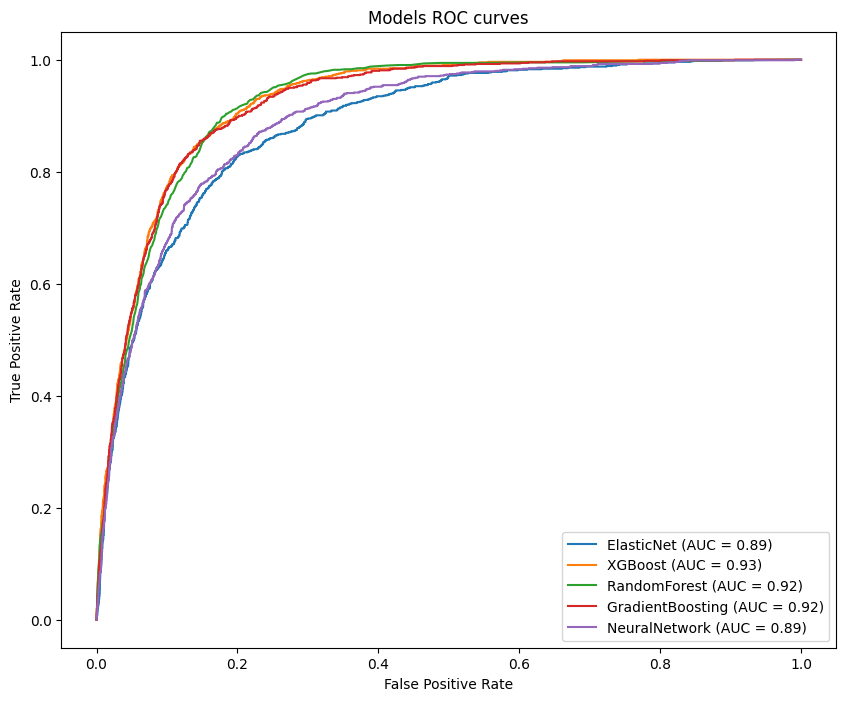


Best overall model: XGBoost with ROC AUC: 0.996900


In [9]:
# Training setup
plt.figure(figsize=(10, 8))
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = {}
best_models = {}
best_scores = {}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for model_name, model in models.items():
    print(f'Training {model_name}...')
    
    if model_name == 'NeuralNetwork':
        # Grid Search manual para la red neuronal
        best_score = -np.inf
        best_params = None
        best_nn_model = None
        
        for lr in param_grids['NeuralNetwork']['learning_rate']:
            for dr in param_grids['NeuralNetwork']['dropout_rate']:
                for units in param_grids['NeuralNetwork']['units']:
                    for hl in param_grids['NeuralNetwork']['hidden_layers']:
                        nn_model = build_model(input_shape=len(X_filtered), learning_rate=lr, dropout_rate=dr, 
                                              units=units, activation='relu', hidden_layers=hl)
                        history = nn_model.fit(X_resample[X_filtered], y_resample, epochs=50, batch_size=32, 
                                              validation_split=0.2, callbacks=[early_stopping], verbose=0)
                        val_auc = max(history.history['val_AUC'])
                        if val_auc > best_score:
                            best_score = val_auc
                            best_params = {'learning_rate': lr, 'dropout_rate': dr, 'units': units, 'hidden_layers': hl}
                            best_nn_model = nn_model

        best_models[model_name] = best_nn_model
        best_scores[model_name] = best_score
        print(f'Best params for {model_name}: {best_params}')
        print(f'Best ROC AUC score for {model_name}: {best_score:.6f}')
        
        # Predicciones
        y_prob = best_nn_model.predict(X_test[X_filtered], verbose=0).ravel()
    else:
        # Grid Search para los otros modelos
        grid_search = GridSearchCV(model, param_grids[model_name], cv=kf, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_resample[X_filtered], y_resample)
        best_models[model_name] = grid_search.best_estimator_
        best_scores[model_name] = grid_search.best_score_
        print(f'Best params for {model_name}: {grid_search.best_params_}')
        print(f'Best ROC AUC score for {model_name}: {grid_search.best_score_:.6f}')
        
        # Predicciones
        y_prob = best_models[model_name].predict_proba(X_test[X_filtered])[:, 1]

    # Evaluación con threshold 0.4
    threshold = 0.4
    y_pred = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives = conf_matrix[0].sum()
    actual_positives = conf_matrix[1].sum()
    false_positive = conf_matrix[0][1]
    false_negative = conf_matrix[1][0]
    false_positive_pct = (false_positive / actual_negatives) * 100
    false_negative_pct = (false_negative / actual_positives) * 100

    # Guardar resultados
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error (%)': false_positive_pct,
        'Type II Error (%)': false_negative_pct,
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Best Params': best_params if model_name == 'NeuralNetwork' else grid_search.best_params_
    }

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['ROC AUC']:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models ROC curves')
plt.legend()
plt.show()

# Seleccionar el mejor modelo basado en ROC AUC
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f'\nBest overall model: {best_model_name} with ROC AUC: {best_scores[best_model_name]:.6f}')

In [10]:
results_df = pd.DataFrame.from_dict(results, orient='index').sort_values(by='ROC AUC', ascending=False)
print("\nResultados finales:")
results_df


Resultados finales:


,Accuracy,Precision,Recall,F1 Score,Type I Error (%),Type II Error (%),ROC AUC,Best Params
XGBoost,0.888864,0.517197,0.753308,0.613313,9.317470,24.669187,0.925315,"{'colsample_bytree': 0.6, 'learning_rate': 0.3..."
RandomForest,0.851487,0.431060,0.842155,0.570240,14.727614,15.784499,0.923345,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
GradientBoosting,0.887427,0.512920,0.750473,0.609363,9.442705,24.952741,0.922282,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
NeuralNetwork,0.808581,0.360778,0.824197,0.501871,19.348779,17.580340,0.894948,"{'learning_rate': 0.0001, 'dropout_rate': 0.2,..."
ElasticNet,0.773748,0.322685,0.849716,0.467742,23.631810,15.028355,0.886278,"{'C': 100, 'l1_ratio': 0.9, 'penalty': 'elasti..."
